Estos ejercicios pretenden poner en práctica la habilidad para crear un modelo sencillo pero completo _end2end_ con la librería __sklearn__ mediante el uso de transformadores _ad hoc_, una batería de algoritmos y un tuneado de parámetros.

Las celdas de control están para asegurar que el código se ha ejecutado tal como se ejecutó en mi máquina.

## Parte 0: Inicialización

En esta parte, simplemente cargamos las librerías que vamos a utilizar y establecemos una semilla para controlar la reproducibilidad del ejercicio.

In [1]:
""" Librerías """

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

""" Semilla """

seed = 99

C:\Users\alvar\AppData\Local\Temp\ipykernel_20548\3137747518.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Comprobamos que tenemos el entorno virtual correctamente creado en la siguiente celda. Si fallase alguno de los *asserts*, significaría que no tenemos la versión correcta:

In [2]:
assert sys.version[0:4] == '3.10'
assert sklearn.__version__ == '1.3.2'
assert matplotlib.__version__ == '3.8.3'
assert sns.__version__ == '0.13.2'
assert pd.__version__ == '2.2.0'
assert np.__version__ == '1.26.4'

## Parte 1: Lectura y transformación de datos

En esta parte, principalmente, cargaremos los datos de un repositorio git y realizaremos una breve limpieza de los datos para conseguir un dataframe listo.

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/eduardofc/data/main/titanic-2.csv')

print(f'Número de filas: {data.shape[0]}, Número de columnas:{data.shape[1]}')
data.head()

Número de filas: 891, Número de columnas:13


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Creamos una columna adicional llamada _hasCabin_ que toma 0 si la columna _Cabin_ es nula y 1 si no lo es. Eliminamos _PassengerId_, _Name_, _Cabin_ y _Ticket_.

In [4]:
# Solo los datos NaN serán 0 (ningún valor de Cabin tiene 0 al principio)
data['Cabin'] = data.Cabin.fillna(0)

# Crea una columna hasCabin donde los datos Cabin que existían 
# originalmente son 1 y los que faltaban 0
data['hasCabin'] = data.Cabin.apply(lambda x: 1 if x!=0 else 0)

# Borra las columnas que se pide
data.drop(columns=['PassengerId','Name','Cabin','Ticket'], inplace=True)

In [5]:
key_cols = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'hasCabin']

assert sum([x in key_cols for x in data.columns]) == 10
assert len(data.columns) == 10
assert (data.groupby('hasCabin').size()[0], data.groupby('hasCabin').size()[1]) == (687, 204)

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,hasCabin
0,0,3,male,22.0,1,0,7.2500,S,Mr,0
1,1,1,female,38.0,1,0,71.2833,C,Mrs,1
2,1,3,female,26.0,0,0,7.9250,S,Miss,0
3,1,1,female,35.0,1,0,53.1000,S,Mrs,1
4,0,3,male,35.0,0,0,8.0500,S,Mr,0


En esta celda modificamos las variables _Title_, _Parch_ y _SibSp_, donde _Title_ tome solo los valores _Mr_, _Mrs_, _Miss_ y _Otros_; y _Parch_ y _SibSp_ toman solo los valores 0, 1 o 2 (donde 2 incluye 2 o más).

In [6]:
# Hace las transformaciones para Title
data['Title'] = data.Title.apply(lambda x: 'Otros' if x not in ['Mr','Mrs','Miss'] else x)

# Hace las transformaciones para Parch y SibSp
data['Parch'] = data.Parch.apply(lambda x: 2 if x >= 2 else x)
data['SibSp'] = data.SibSp.apply(lambda x: 2 if x >= 2 else x)

Celda de control:

In [7]:
assert (data.groupby('SibSp').size()[0], data.groupby('SibSp').size()[1], data.groupby('SibSp').size()[2]) == (608, 209, 74)
assert (data.groupby('Parch').size()[0], data.groupby('Parch').size()[1], data.groupby('Parch').size()[2]) == (678, 118, 95)
assert (data.groupby('Title').size()['Mr'], data.groupby('Title').size()['Mrs'], data.groupby('Title').size()['Miss'], data.groupby('Title').size()['Otros']) == (517, 125, 182, 67)
assert len(data) == 891

Eliminamos los dos registros cuyo valor _Embarked_ es nulo. Además eliminamos duplicados.

In [8]:
data.dropna(axis=0, subset=['Embarked'], inplace=True)
data.drop_duplicates(inplace=True)

Celda de control:

In [9]:
assert len(data) == 787
assert (data.groupby('Embarked').size()['C'], data.groupby('Embarked').size()['S'], data.groupby('Embarked').size()['Q']) == (155, 572, 60)
assert data.Age.isnull().sum() == 109
assert data.duplicated().sum() == 0

Creamos una variable llamada *col_transformer* un ColumnTransformer que lleva en orden:
- Un KNN Imputer de 5 vecinos con métrica *nan_euclidean* y pesos uniformes, para _Pclass_, _Age_, _SibSp_, _Parch_, _Fare_.
- Un PowerTransformer _yeo-johnson_ para _Fare_.
- Un OneHotEncoder para las variables _Sex_ (con la opción *drop=if_binary*), _Embarked_ (con la opción *drop=first*),  _Title_ y _Parch_ (sin opciones especiales).

El ColumnTransfomer tiene una opción llamada _reminder_ que asignaremos valor _drop_. Aunque lo normal en la mayoría de los casos es utilizar la opción _passthrough_ en este caso creo que _drop_ es mejor 

_Nota_: Para que la celda de control no falle, es importante poner en orden tanto los transformadores como las variables.

In [10]:
# Los steps individuales están en el orden en que se mencionan en el enunciado
col_transformer = ColumnTransformer([
    ('KNN', KNNImputer(n_neighbors=5, metric='nan_euclidean', weights='uniform'), ['Pclass', 'Age', 'SibSp' ,'Parch', 'Fare']),
    ('PowerTransform', PowerTransformer(method='yeo-johnson'), ['Fare']),
    ('ohe1', OneHotEncoder(drop='if_binary'), ['Sex']),
    ('ohe2', OneHotEncoder(drop='first'), ['Embarked']),
    ('ohe3', OneHotEncoder(), ['Title', 'Parch'])
], remainder='drop')

Celda de control:

In [11]:
ctransformed = col_transformer.fit_transform(data)

assert ctransformed.shape == (787, 16)
assert sum(np.round(ctransformed[1],2) == [1.,38.,1.,0.,71.28,1.27,0.,0.,0.,0.,0.,1.,0.,1.,0.,0.]) == 16
assert sum(np.round(ctransformed[100],2) == [3.,21.2,0.,0.,7.78,-0.9,1.,0.,1.,0.,1.,0.,0.,1.,0.,0.]) == 16

## Parte 2: Selección de modelo

En esta parte, evaluaremos diversos estimadores (algoritmos, transformadores+algoritmos) con el objeto de predecir la variable objetivo (_Survived_) y estudiar su comportamiento.

In [12]:
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC()))

X = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'hasCabin']]
y = data['Survived']

def boxplots_algorithms(results, names):
    
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()

Ahora, realizaremos un bucle que calcule, para cada algoritmo de la variable _models_,

- Un pipeline que realice:
    1. El ColumnTransformer diseñado anteriormente
    2. Un RobustScaler a continuación y, finalmente, 
    3. Evalue cada algoritmo 

- Una validación cruzada:
    1. Tipo KFolds, con 10 _folders_ 
    2. Aleatorio con semilla _seed_ y,
    3. _scoring='accuracy'_
        
En cada iteración del bucle, almacenamos el resultado de cada validación cruzada en una variable _results_ y los nombres de cada algoritmo en una variable _names_.

Finalmente, usaremos la función *boxplots_algorithms* para dibujar los resultados.

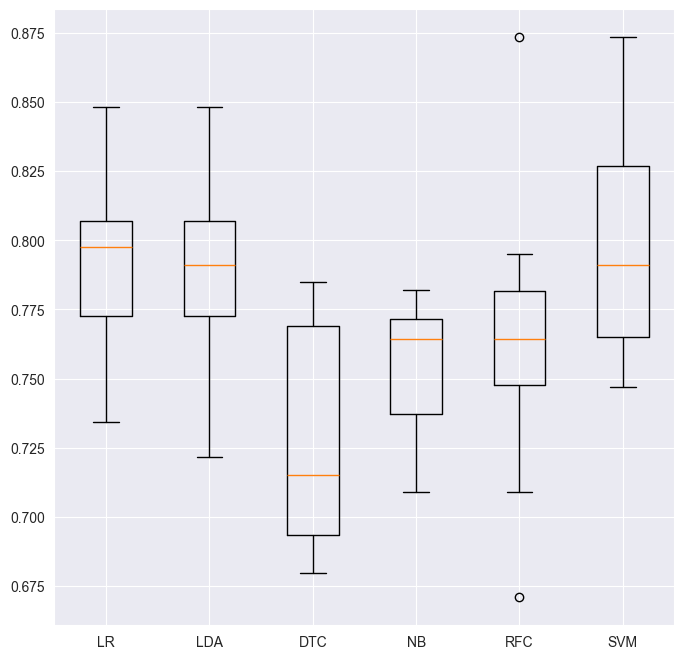

In [13]:
results = []
names = []

for name, model in models:
    # Define la pipeline con un modelo escogido de la lista en cada iteración
    pl = Pipeline([
        ('column_trans', col_transformer),
        ('scaler', RobustScaler()),
        ('model', model)
        ])
    
    # Hace la validación cruzada
    cv_technique = KFold(n_splits=10, shuffle=True, random_state=seed)
    # Almacena el resultado de la iteración en result
    result = cross_val_score(pl, X, y, cv=cv_technique)
    
    # Guarda el nombre del modelo y su resultado en names y results
    names.append(name)
    results.append(result)

boxplots_algorithms(results, names)

Celda de control:

In [14]:
assert len(results) == len(models)
assert [np.round(x[4],2) for x in results] == [0.8, 0.78, 0.73, 0.77, 0.71, 0.76]

## Parte 3: Tuneado del modelo

En esta parte, elegiremos un modelo compuesto por transformaciones y un algoritmo seleccionado. En concreto, probaremos diferentes parametrizaciones del algoritmo para obtener la mejor métrica.

Ahora, realizaremos un tuneado del _RandomForestClassifier_ con _GridSearchCV_ para estimar cuál es la mejor configuración paramétrica entre:

- 10 y 20 estimadores,
- maximo número de variables estimado con los algoritmos _auto_, _sqrt_ y _log2_, 
- máxima profundidad 4,5,6,7 u 8,
- criterio para medir la calidad del _split_ entre _gini_ o _entropy_
    
El modelo final, entrenado con _GridSearchCV_ y las variables _(X, y)_, se almacenará en una variable llamada _grid_model_. 

El entrenamiento del modelo se hará con un _StratifiedKfolds_ de 10 folders aleatorio.

Se utilizará el mismo *Pipeline* que en el apartado anterior, salvo que solo con el modelo de Random Forest.

Nota: Aquí no hago ningún train test split. 

In [15]:
grid_model = None 

# YOUR CODE HERE
pl = Pipeline([
    ('column_trans', col_transformer),
    ('scaler', RobustScaler()),
    ('model', RandomForestClassifier(random_state=seed))
    ])

parametros = {
    "model__criterion": ['gini', 'entropy'],
    "model__n_estimators": [10,20],
    "model__max_depth": [4,5,6,7,8],
    "model__max_features": ['auto', 'sqrt', 'log2']
}

grid_model = GridSearchCV(pl, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=seed), scoring='accuracy', param_grid=parametros)
grid_model.fit(X,y)

print(grid_model.best_score_)
print(grid_model.best_estimator_)

0.80688088283025
Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('KNN', KNNImputer(),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('PowerTransform',
                                                  PowerTransformer(),
                                                  ['Fare']),
                                                 ('ohe1',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Sex']),
                                                 ('ohe2',
                                                  OneHotEncoder(drop='first'),
                                                  ['Embarked']),
                                                 ('ohe3', OneHotEncoder(),
                                                  ['Tit

Celda de control:

In [16]:
assert np.round(grid_model.best_score_, 4) == 0.8069
assert len(grid_model.best_estimator_.steps) == 3